In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


### Load the cleaned dataset of pneumonia patients into a DataFrame


In [2]:
df = pd.read_csv("cleaned_data_of_pneumonia_patients 1.csv")

### Transforming `ICD9_CODE_HISTORY` to Dummy Variables
   - Use `eval()` to convert string representations of lists into actual lists, and replace non-list values with empty lists.
   - Combine list elements with a delimiter (`|`) and apply `get_dummies()` to create binary-encoded columns for each unique value.
   - Drop the original `ICD9_CODE_HISTORY` column and concatenate the dummy variable DataFrame with the original DataFrame.


In [3]:
df['ICD9_CODE_HISTORY'] = df['ICD9_CODE_HISTORY'].apply(lambda x: eval(x) if isinstance(x, str) else [])
icd9_dummies = df['ICD9_CODE_HISTORY'].str.join('|').str.get_dummies()
df = pd.concat([df.drop(columns=['ICD9_CODE_HISTORY']), icd9_dummies], axis=1)

### Data Preprocessing
   - Use `pd.get_dummies()` to convert categorical columns (`GENDER`, `ADMISSION_TYPE`, `ETHNICITY`) into dummy variables. The `drop_first=True` option ensures that the first category of each column is dropped to avoid multicollinearity.
   - Use `dropna()` to remove any rows with missing values.



In [4]:
df = pd.get_dummies(df, columns=['GENDER', 'ADMISSION_TYPE', 'ETHNICITY'], drop_first=True)
df = df.dropna()

### Splitting Data into Features and Target
- **Features (X)**: All columns except `SUBJECT_ID`, `HADM_ID`, `ADMITTIME`, `DOB`, and `Pneumonia`.
- **Target (y)**: The `Pneumonia` column.


In [5]:
X = df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DOB', 'Pneumonia'])
y = df['Pneumonia']

### Train-Test Split
   - Split the data into training and validation/test sets with an 80-20 ratio.
   - Split the validation/test set into separate validation and test sets, each with a 50% share of the validation/test data.

In [6]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.2, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=13)

### Model Training
   - A `RandomForestClassifier` is instantiated with 100 trees (`n_estimators=100`) and a fixed random seed (`random_state=13`) to ensure reproducibility.
   - The model is trained using the training data (`X_train`, `y_train`), allowing it to learn patterns for predicting pneumonia.


In [7]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier()

random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, n_jobs=-1)

random_search.fit(X_train, y_train)
print(f"Best parameters: {random_search.best_params_}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
300 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
119 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\PSL\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\PSL\anaconda3\Lib\site-packages\sklearn

Best parameters: {'oob_score': False, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}


### Model Evaluation
   - The model's accuracy on the validation set (`X_val`, `y_val`) is calculated using `model.score()`. This gives an indication of how well the model generalizes to unseen data.
   - The model's accuracy on the test set (`X_test`, `y_test`) is calculated, providing a final performance measure after training and validation.

In [8]:
val_score = random_search.score(X_val, y_val)
test_score = random_search.score(X_test, y_test)
print(f"Validation Accuracy: {val_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

Validation Accuracy: 0.9240
Test Accuracy: 0.9147


### Model Evaluation with Classification Report
   - The model makes predictions on the test set (`X_test`) using `model.predict()`, resulting in `y_pred`.
   - The classification report is printed to provide a deeper understanding of the model's performance on the test set.


In [9]:
y_pred = random_search.predict(X_test)
report = classification_report(y_test, y_pred, zero_division=0)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       565
           1       0.87      0.94      0.90       396

    accuracy                           0.91       961
   macro avg       0.91      0.92      0.91       961
weighted avg       0.92      0.91      0.92       961



### Confusion Matrix Visualization
   - The `ConfusionMatrixDisplay()` is used to visualize the confusion matrix.



<Figure size 800x600 with 0 Axes>

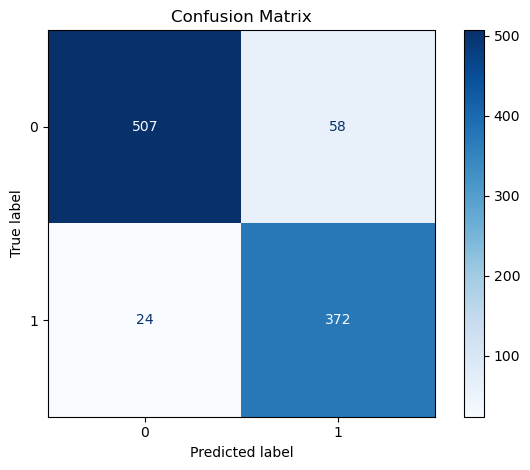

In [10]:
report_conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=report_conf).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Feature Importance Visualization
   - The `feature_importances_` attribute of the trained model is used to obtain the importance of each feature in predicting the target variable.
   - The top 50 most important features are selected using `head(50)` for visualization.
   - A horizontal bar plot is created to visualize the top 50 feature importances. The bars are colored with a steel blue shade and outlined in black for clarity.

4019 Hypertension NOS
age_at_admission
ADMISSION_TYPE_EMERGENCY
41401 Crnry athrscl natve vssl
25000 DMII wo cmp nt st uncntr
2720 Pure hypercholesterolem
V290 NB obsrv suspct infect
V053 Need prphyl vc vrl hepat
ADMISSION_TYPE_NEWBORN
2859 Anemia NOS
51881 Acute respiratry failure
42731 Atrial fibrillation
53081 Esophageal reflux
V3000 Single lb in-hosp w/o cs
2449 Hypothyroidism NOS
3051 Tobacco use disorder
0389 Septicemia NOS
2724 Hyperlipidemia NEC/NOS
V3001 Single lb in-hosp w cs
2765 Volume depletion disorder


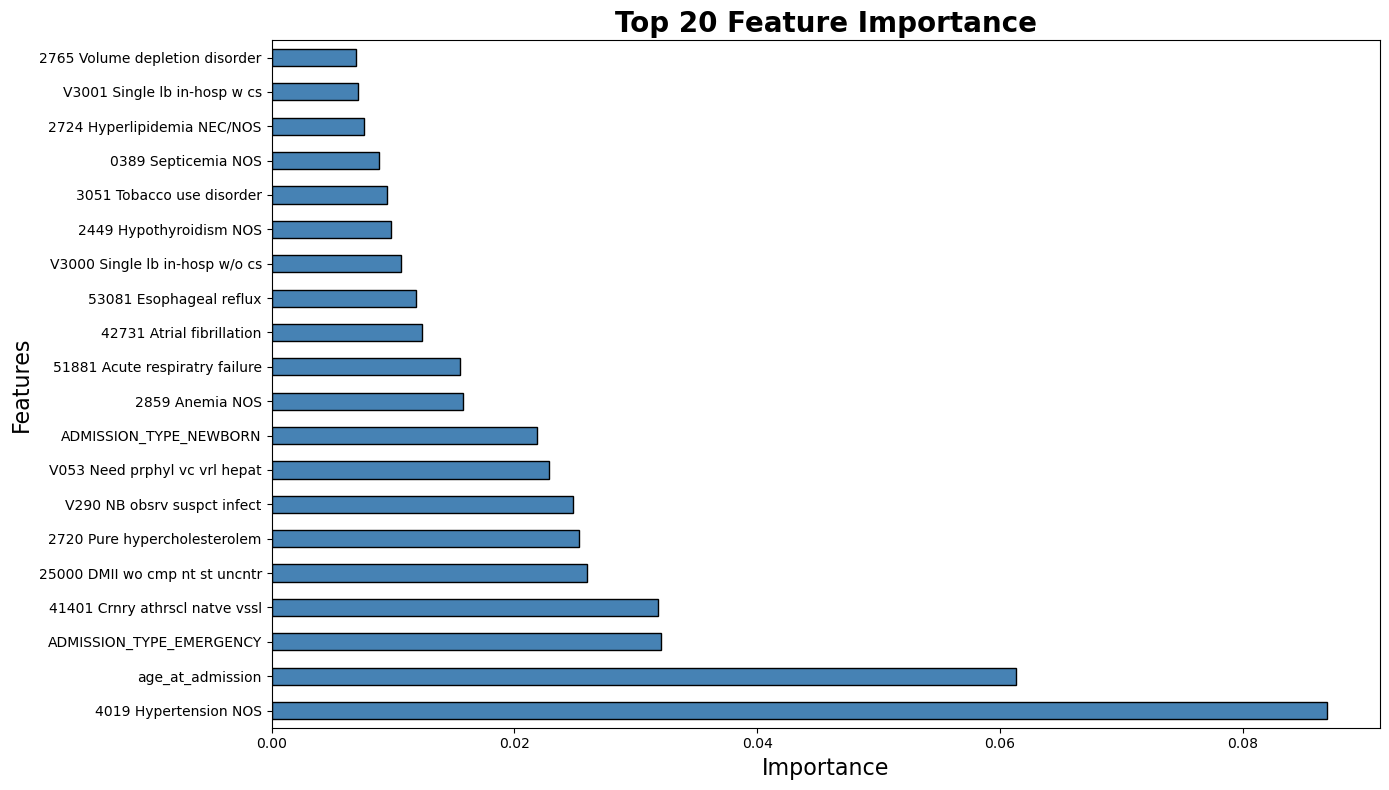

In [11]:
from icd9cms.icd9 import search

importances = random_search.best_estimator_.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
top_50_features = feature_importances.head(20)

long_descs = []
for feature in top_50_features.index:
    result = search(feature)
    long_desc = f"{result.code} {result.short_desc}" if result else feature
    long_descs.append(long_desc)
for long_desc in long_descs:
    print(long_desc)
    
plt.figure(figsize=(14, 8))
top_50_features.plot(kind='barh', color='steelblue', edgecolor='black')

plt.yticks(ticks=range(len(top_50_features)), labels=long_descs)

plt.title('Top 20 Feature Importance', fontsize=20, fontweight='bold')
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)

plt.tight_layout()
plt.savefig('random_forest_feature_importance.png')
plt.show()


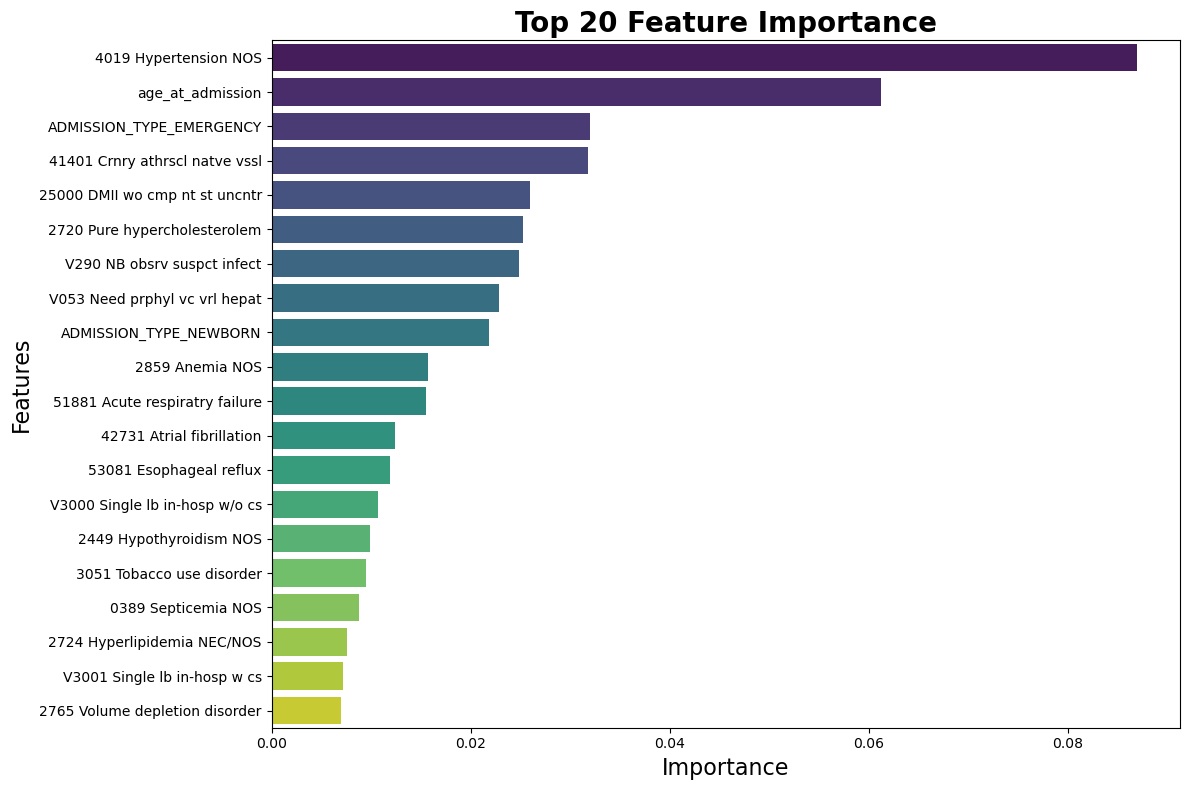

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from icd9cms.icd9 import search

# Get top 20 feature importances
importances = random_search.best_estimator_.feature_importances_
feature_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
top_20_features = feature_importances.head(20)

# Map feature codes to long descriptions
long_descs = []
for feature in top_20_features.index:
    result = search(feature)
    long_desc = f"{result.code} {result.short_desc}" if result else feature
    long_descs.append(long_desc)

# Create a DataFrame for Seaborn
df_plot = pd.DataFrame({
    'Feature': long_descs,
    'Importance': top_20_features.values
})

# Reverse the order for Seaborn to show top features at top
plt.figure(figsize=(12, 8))
sns.barplot(data=df_plot, y='Feature', x='Importance', palette='viridis')

plt.title('Top 20 Feature Importance', fontsize=20, fontweight='bold')
plt.xlabel('Importance', fontsize=16)
plt.ylabel('Features', fontsize=16)

plt.tight_layout()
plt.savefig('random_forest_feature_importance_seaborn.png')
plt.show()


In [13]:
y_pred_prob = random_search.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.9818


### Cross-Validation with ROC Curves and Performance Metrics

   - The `StratifiedKFold` method is used for 5-fold cross-validation, ensuring that each fold has a similar distribution of the target variable (`y`).
   - For each fold, a `RandomForestClassifier` model is trained on the training set and evaluated on the test set.  
   - The ROC curve for each fold is plotted, with the `AUC` score displayed in the legend for each fold. A diagonal line is plotted to represent a random classifier.
   - The plot is displayed showing the ROC curves for all folds, and performance metrics are printed for each fold.


Fold 1: AUC: 0.9795, Sensitivity: 0.9515, Specificity: 0.8990, PPV: 0.8663, NPV: 0.9642
Fold 2: AUC: 0.9840, Sensitivity: 0.9515, Specificity: 0.9157, PPV: 0.8859, NPV: 0.9648
Fold 3: AUC: 0.9790, Sensitivity: 0.9515, Specificity: 0.8787, PPV: 0.8437, NPV: 0.9634
Fold 4: AUC: 0.9798, Sensitivity: 0.9464, Specificity: 0.9077, PPV: 0.8759, NPV: 0.9609
Fold 5: AUC: 0.9829, Sensitivity: 0.9553, Specificity: 0.9077, PPV: 0.8769, NPV: 0.9672


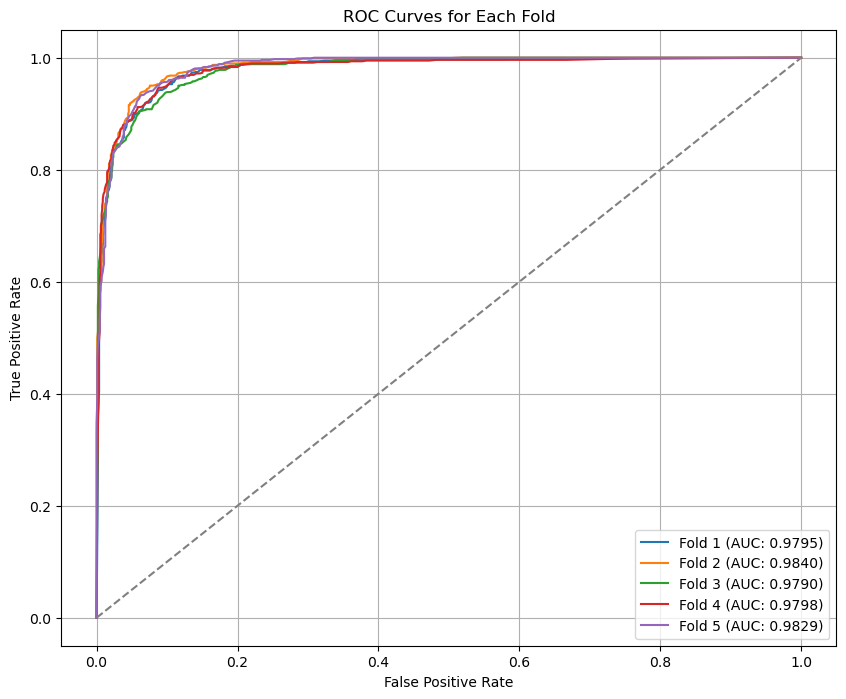

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)

aucs = []
sensitivities = []
specificities = []
ppvs = []
npvs = []

plt.figure(figsize=(10, 8))  

for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    best_params = random_search.best_params_
    
    model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    oob_score=best_params['oob_score'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    max_depth=best_params['max_depth'],
    random_state=13,
    criterion=best_params['criterion'],
    bootstrap=best_params['bootstrap']
    )
    
    model.fit(X_train, y_train)

    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    auc_score = roc_auc_score(y_test, y_pred_prob)
    aucs.append(auc_score)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'Fold {fold} (AUC: {auc_score:.4f})')

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    sensitivity = tp / (tp + fn)
    sensitivities.append(sensitivity)

    specificity = tn / (tn + fp)
    specificities.append(specificity)

    ppv = tp / (tp + fp)
    ppvs.append(ppv)

    npv = tn / (tn + fn)
    npvs.append(npv)

    print(
        f"Fold {fold}: AUC: {auc_score:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, PPV: {ppv:.4f}, NPV: {npv:.4f}"
    )
    
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

### Summary of Metrics across Folds
   - For each metric (AUC, Sensitivity, Specificity, PPV, and NPV), the mean and standard deviation are calculated across all 5 folds.
   - The 95% confidence interval (CI) for each metric is computed.

In [15]:
print("Summary of Metrics across folds:\n")

mean_auc = np.mean(aucs)
std_auc = np.std(aucs, ddof=1)
ci_auc = 1.96 * (std_auc / np.sqrt(len(aucs)))
print(f"Mean AUC: {mean_auc:.4f} +/- {std_auc:.4f} (95% CI: [{mean_auc - ci_auc:.4f}, {mean_auc + ci_auc:.4f}])")

mean_sens = np.mean(sensitivities)
std_sens = np.std(sensitivities, ddof=1)
ci_sens = 1.96 * (std_sens / np.sqrt(len(sensitivities)))
print(f"Mean Sensitivity: {mean_sens:.4f} +/- {std_sens:.4f} (95% CI: [{mean_sens - ci_sens:.4f}, {mean_sens + ci_sens:.4f}])")

mean_spec = np.mean(specificities)
std_spec = np.std(specificities, ddof=1)
ci_spec = 1.96 * (std_spec / np.sqrt(len(specificities)))
print(f"Mean Specificity: {mean_spec:.4f} +/- {std_spec:.4f} (95% CI: [{mean_spec - ci_spec:.4f}, {mean_spec + ci_spec:.4f}])")

mean_ppv = np.mean(ppvs)
std_ppv = np.std(ppvs, ddof=1)
ci_ppv = 1.96 * (std_ppv / np.sqrt(len(ppvs)))
print(f"Mean PPV: {mean_ppv:.4f} +/- {std_ppv:.4f} (95% CI: [{mean_ppv - ci_ppv:.4f}, {mean_ppv + ci_ppv:.4f}])")

mean_npv = np.mean(npvs)
std_npv = np.std(npvs, ddof=1)
ci_npv = 1.96 * (std_npv / np.sqrt(len(npvs)))
print(f"Mean NPV: {mean_npv:.4f} +/- {std_npv:.4f} (95% CI: [{mean_npv - ci_npv:.4f}, {mean_npv + ci_npv:.4f}])")


Summary of Metrics across folds:

Mean AUC: 0.9810 +/- 0.0023 (95% CI: [0.9790, 0.9830])
Mean Sensitivity: 0.9512 +/- 0.0032 (95% CI: [0.9484, 0.9540])
Mean Specificity: 0.9018 +/- 0.0142 (95% CI: [0.8894, 0.9142])
Mean PPV: 0.8697 +/- 0.0161 (95% CI: [0.8556, 0.8838])
Mean NPV: 0.9641 +/- 0.0023 (95% CI: [0.9621, 0.9661])
